In [1]:
# Do not use GPUs
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# model with padded convolutions for the fashion mnist dataset
from numpy import mean, std, argmax
from numpy.random import randint
from matplotlib import pyplot
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD

import warnings
warnings.filterwarnings("ignore")
from tensorflow.python.client import device_lib

2023-12-04 07:42:12.162068: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-04 07:42:13.346677: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# shows GPUs (if any)
def show_gpus():
    print('Available GPUs')
    for d in device_lib.list_local_devices():
        print(d.physical_device_desc)

# load train and test dataset
def load_dataset():
	# load dataset
	(trainX, trainY), (testX, testY) = fashion_mnist.load_data()
	# reshape dataset to have a single channel
	trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
	testX = testX.reshape((testX.shape[0], 28, 28, 1))
	# one hot encode target values
	trainY = to_categorical(trainY)
# 	testY = to_categorical(testY)
	return trainX, trainY, testX, testY

def get_feature_name(id):
    human_readable_lablels = ["T-shirt/top",  #  0
                        "Trouser",            #  1
                        "Pullover",           #  2   
                        "Dress",              #  3 
                        "Coat",               #  4
                        "Sandal",             #  5
                        "Shirt",              #  6 
                        "Sneaker",            #  7 
                        "Bag",                #  8 
                        "Ankle boot"]         #  9
    return human_readable_lablels[id]

def show_images(ds_x, ds_y, num_row, num_col):  
    fig, axes = pyplot.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))

    for i in range(num_row*num_col):
        img_id = randint(len(ds_y))
        ax = axes[i//num_col, i%num_col]
        ax.imshow(ds_x[img_id], cmap='gray_r')
        ylabel = argmax(ds_y[img_id])
        ax.set_title('{}:{}'.format(get_feature_name(ylabel), ylabel))
        ax.set_xticks([])
        ax.set_yticks([])
    pyplot.tight_layout()

# scale pixels
def scale_images(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    # compile model
    model.compile(optimizer=SGD(lr=0.01, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
#     model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model
    
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
    scores, histories, models = list(), list(),list()
    # prepare cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    fold=0
    for train_ix, test_ix in kfold.split(dataX):
        fold = fold + 1
        # define model
        model = define_model()
        if fold==1:
            model.summary()
        # select rows for train and test
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        print('Fitting/evaluating fold:', fold, 'out of', kfold.n_splits)
        # fit model
        history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
        # evaluate model
        loss, acc = model.evaluate(testX, testY, verbose=0)
        print('> %.3f' % (acc * 100.0))
        # append scores
        scores.append(acc)
        histories.append(history)
        models.append(model)
    return scores, histories, models


def create_model(dataX, dataY):
    model = define_model()
    history = model.fit(dataX, dataY, epochs=10, batch_size=32)
    return model, history

# plot diagnostic learning curves
def summarize_diagnostics(histories):
    pyplot.figure(figsize=(16,4))
    tics = histories[0].epoch
    
    for i in range(len(histories)):
        # plot loss
        pyplot.subplot(121)
        pyplot.title('Cross Entropy Loss')
        pyplot.plot(histories[i].history['loss'], color='blue', label='train')
        pyplot.plot(histories[i].history['val_loss'], color='orange', label='test')
        if i==0:
            pyplot.legend(loc="upper right")
 
        # plot accuracy
        pyplot.subplot(122)
        pyplot.title('Classification Accuracy')
        pyplot.plot(histories[i].history['accuracy'], color='blue', label='train')
        pyplot.plot(histories[i].history['val_accuracy'], color='orange', label='test')
        if i==0:
            pyplot.legend(loc="lower right") 
            pyplot.xlabel('Fashion class')
            pyplot.xticks(tics)
    
    pyplot.subplot(121)
    pyplot.xlabel('Epoch')
    pyplot.xticks(tics)
    pyplot.subplot(122)
    pyplot.xlabel('Epoch')
    pyplot.xticks(tics)
    
    pyplot.show()

In [3]:
show_gpus()

Available GPUs



2023-12-04 07:42:14.536533: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-12-04 07:42:14.536581: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: bsgz402
2023-12-04 07:42:14.536590: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: bsgz402
2023-12-04 07:42:14.536782: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 535.129.3
2023-12-04 07:42:14.536809: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 535.129.3
2023-12-04 07:42:14.536816: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 535.129.3


In [4]:
# load dataset
trainX, trainY, testX, testY = load_dataset()

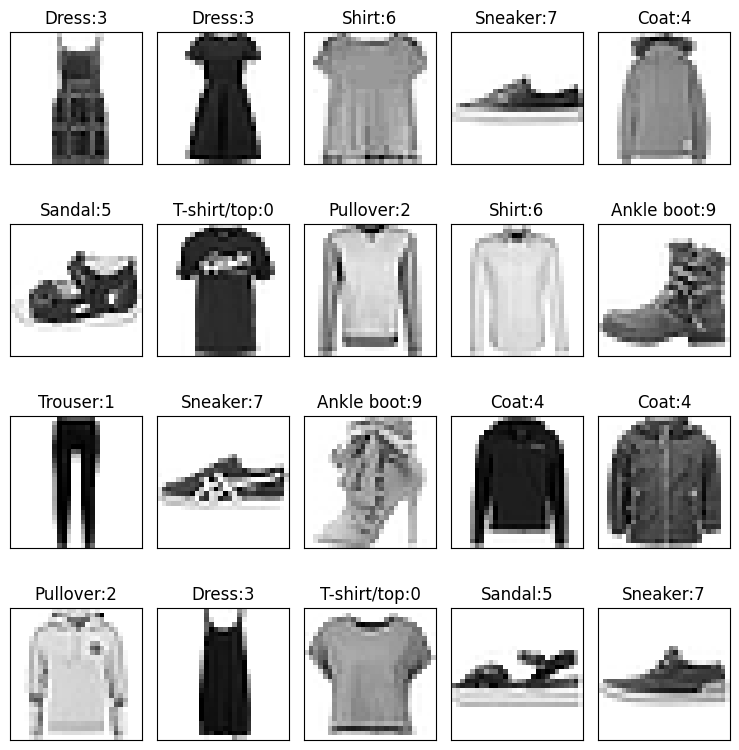

In [5]:
show_images(trainX, trainY, 4,5)

In [6]:
# prepare pixel data

trainX, testX = scale_images(trainX, testX)

In [7]:
# evaluate model
scores, histories, models = evaluate_model(trainX, trainY)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense (Dense)               (None, 100)               627300    
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
Total params: 628630 (2.40 MB)
Trainable params: 628630 (2.40 MB)
Non-trainable params: 0 (0.00 Byte)
____________________

> 90.642
Fitting/evaluating fold: 2 out of 5


> 90.950
Fitting/evaluating fold: 3 out of 5


> 91.242
Fitting/evaluating fold: 4 out of 5


> 90.733
Fitting/evaluating fold: 5 out of 5
> 91.100


Accuracy: mean=90.933%, min=90.642%, max=91.242%, n. of tests=n=5


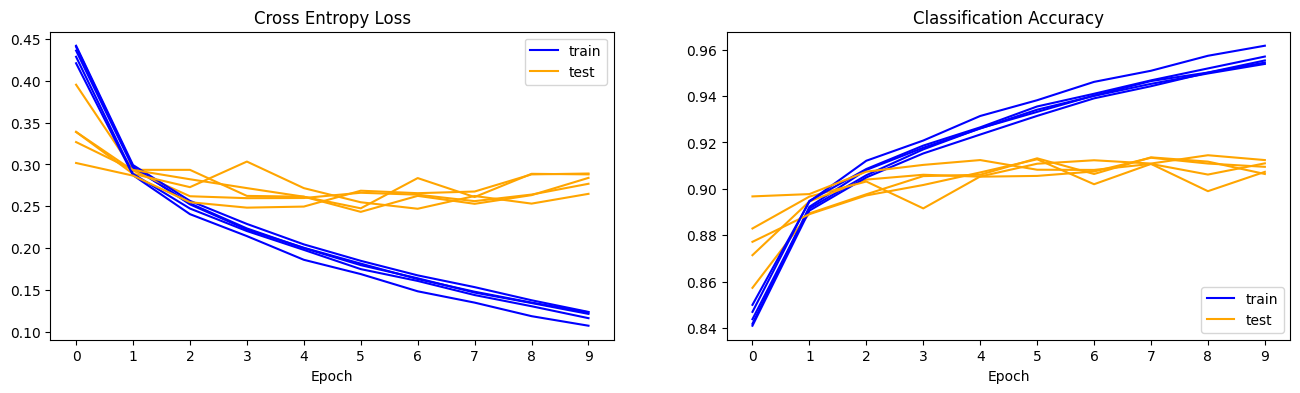

In [8]:
# learning curves
print('Accuracy: mean=%.3f%%, min=%.3f%%, max=%.3f%%, n. of tests=n=%d' % (mean(scores)*100, min(scores)*100, max(scores)*100, len(scores)))
summarize_diagnostics(histories)

## Evaluate the model on unforeseen new data

In [9]:
model, history = create_model(trainX, trainY)

Epoch 1/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.3977 - accuracy: 0.8588
Epoch 2/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2745 - accuracy: 0.8981
Epoch 3/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.2325 - accuracy: 0.9140
Epoch 4/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.2064 - accuracy: 0.9240
Epoch 5/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.1855 - accuracy: 0.9312
Epoch 6/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.1648 - accuracy: 0.9389
Epoch 7/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.1469 - accuracy: 0.9460
Epoch 8/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.1323 - accuracy: 0.9505
Epoch 9/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.1192 - accuracy: 0.9561
Epoch 10/10
1875/1875 [==============================] - 11s 6ms/step - l

In [10]:
ypred = model.predict(testX)
ypred_class = argmax(ypred, axis=1)

313/313 [==============================] - 1s 2ms/step


In [11]:
miss_predictions = []
for i in range(len(ypred_class)):
    if ypred_class[i] != testY[i]:
        miss_predictions.append(i)

In [12]:
nmiss = len(miss_predictions)
acc = 1. - nmiss/len(ypred)
print('accuracy: {:.2f}%%'.format(acc*100))

accuracy: 90.53%%


In [13]:
# Alteratively:
loss, acc = model.evaluate(testX, to_categorical(testY), verbose=0)
print('Loss {}  Accuracy {}'.format(loss, acc))

Loss 0.3155393898487091  Accuracy 0.9053000211715698


In [14]:
ypred2 = models[0].predict(testX)
ypred2_class = argmax(ypred2, axis=1)

313/313 [==============================] - 1s 2ms/step


In [15]:
miss_predictions2 = []
for i in range(len(ypred_class)):
    if ypred2_class[i] != testY[i]:
        miss_predictions2.append(i)
#         print('adding ',i, ' true:', testY[i], ' pred ', ypred2_class[i])
acc2 = 1 - len(miss_predictions2)/len(ypred2_class)
print('accuracy: {:.2f}%%'.format(acc*100))

accuracy: 90.53%%


In [16]:
def describe_prediction(image_id, data, pred, test):
    print('Testing image id', image_id)
    print('true label      {} {}'.format(test[image_id], get_feature_name(test[image_id])))
    print('Class probabilities:')
    for cl, prob in zip([0,1,2,3,4,5,6,7,8,9],pred[image_id]):
        print('class {} {:15s} confidence {:8.4f}%'.format(cl, get_feature_name(cl), prob*100))

    pyplot.imshow(data[image_id].reshape(28,28), cmap='gray_r')

Testing image id 141
true label      0 T-shirt/top
Class probabilities:
class 0 T-shirt/top     confidence  36.3195%
class 1 Trouser         confidence   0.0000%
class 2 Pullover        confidence  15.3088%
class 3 Dress           confidence   0.6133%
class 4 Coat            confidence   0.0017%
class 5 Sandal          confidence   0.0000%
class 6 Shirt           confidence  47.7564%
class 7 Sneaker         confidence   0.0001%
class 8 Bag             confidence   0.0000%
class 9 Ankle boot      confidence   0.0002%


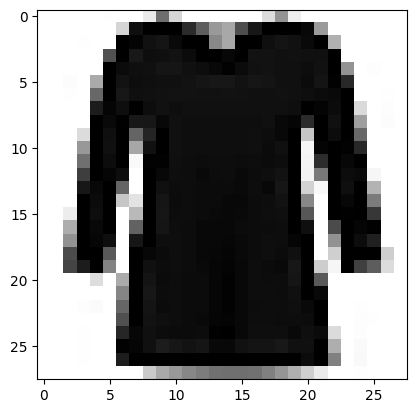

In [17]:
miss_image_id=10

describe_prediction(miss_predictions2[miss_image_id], testX, ypred2, testY)